In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import img_to_array, load_img
import random


np.random.seed(1000)
# ignore information messgaes from tensorflow, but we will receieve error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

In [3]:
import os
import numpy as np
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate
import tensorflow as tf
import tensorflow.keras

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json, Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
# from keras.utils.vis_utils import plot_model

In [4]:
DATA_DIR = '/content/drive/MyDrive/sign_prediction_new/sign_dataset'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test')

In [5]:
IMG_SIZE = 64
CATEGORIES = []
for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
print(CATEGORIES)

['4', '17', '9', '0', '35', '3', '10', '20', '32', '7', '24', '16', '14', '8', '33', '37', '34', '19', '27', '15', '28', '13', '22', '31', '29', '25', '11', '30', '1', '2', '6', '21', '26', '23', '5', '18', '36', '12']


In [6]:
classes = len(CATEGORIES)

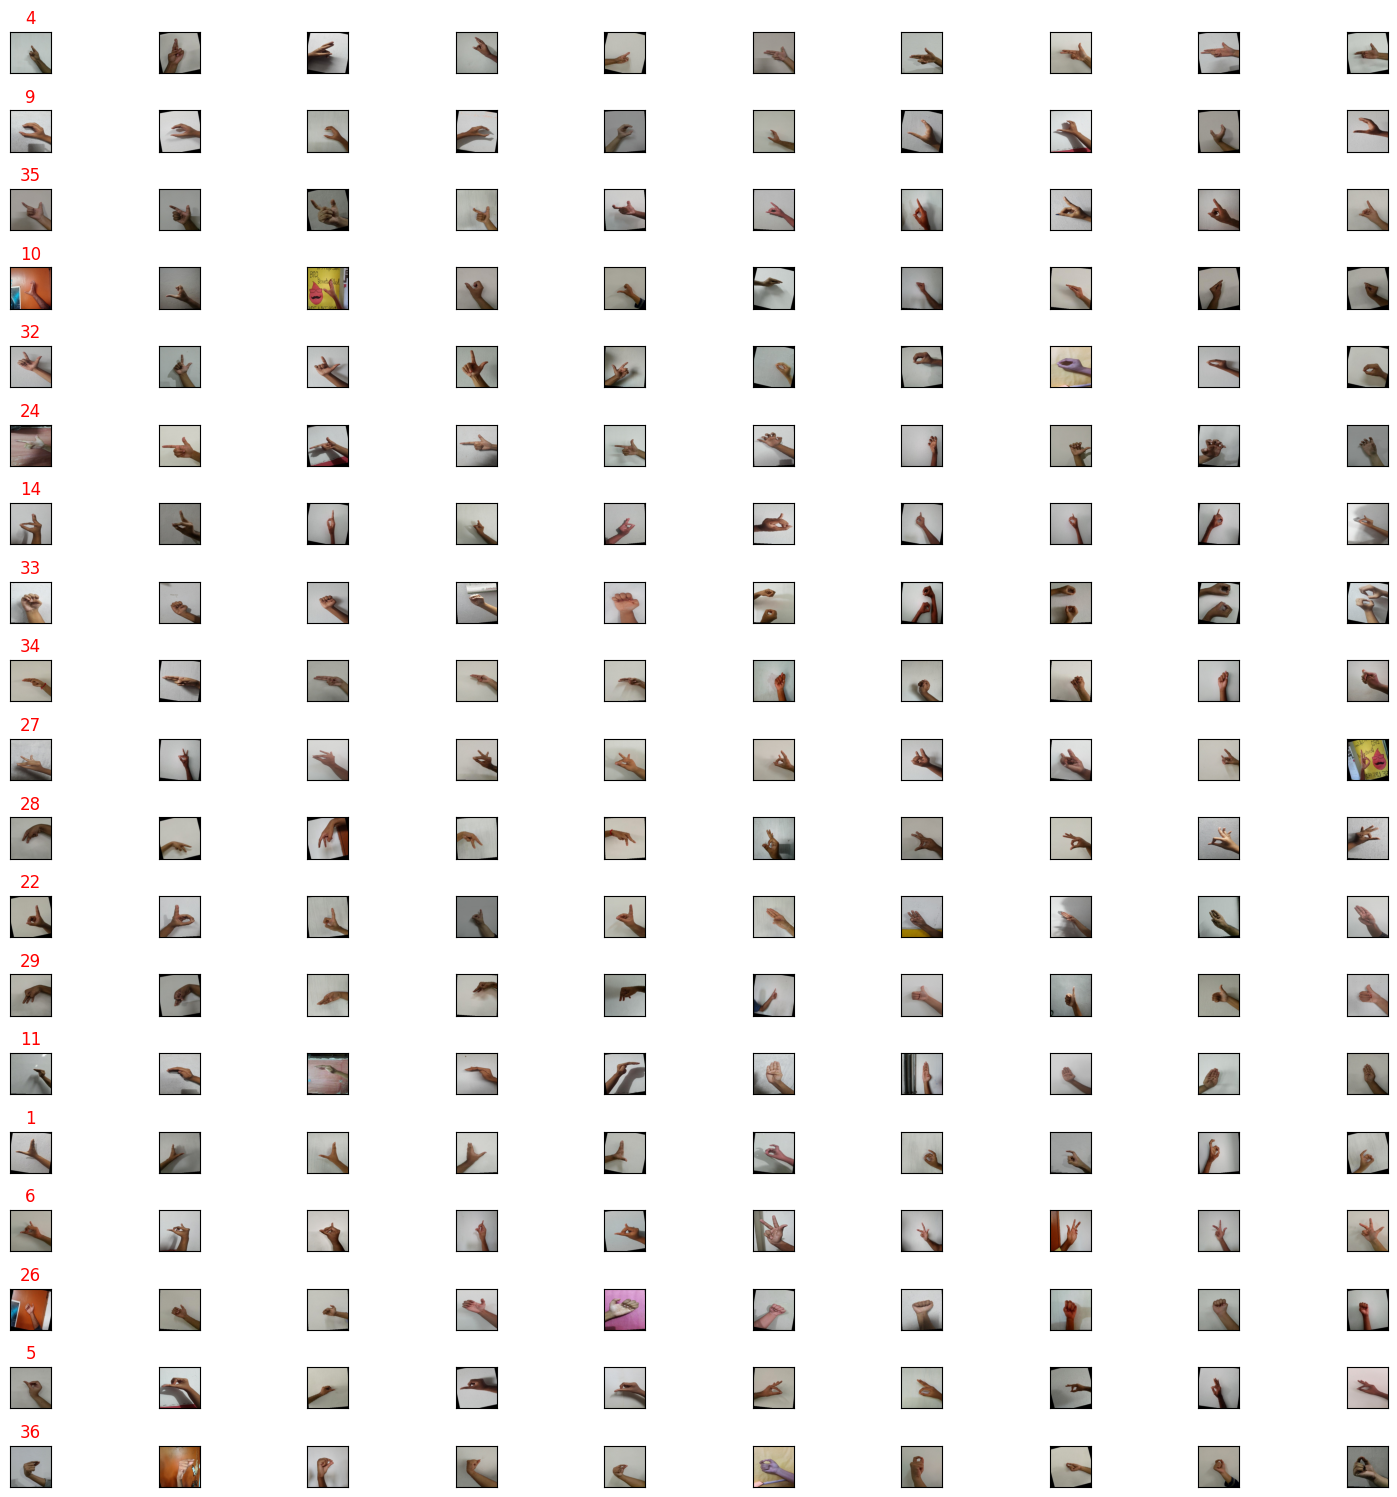

In [7]:
plt.figure(figsize=(15, 30), facecolor='white')
i = 1
num_images_per_class = 5

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    image_list = os.listdir(path)
    if len(image_list) < num_images_per_class:
        continue
    random.shuffle(image_list)
    image_list = image_list[:num_images_per_class]

    for img_name in image_list:
        img_array = cv2.imread(os.path.join(path, img_name))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        white_background = 255 * np.ones_like(img_array)

        x_offset = (white_background.shape[1] - img_array.shape[1]) // 2
        y_offset = (white_background.shape[0] - img_array.shape[0]) // 2
        white_background[y_offset:y_offset + img_array.shape[0], x_offset:x_offset + img_array.shape[1], :] = img_array

        plt.subplot(38, 10, i)
        plt.imshow(white_background)

        if i % 10 == 1:
            plt.title(c, color='red')

        plt.xticks([])
        plt.yticks([])
        i += 1

plt.tight_layout()
plt.show()

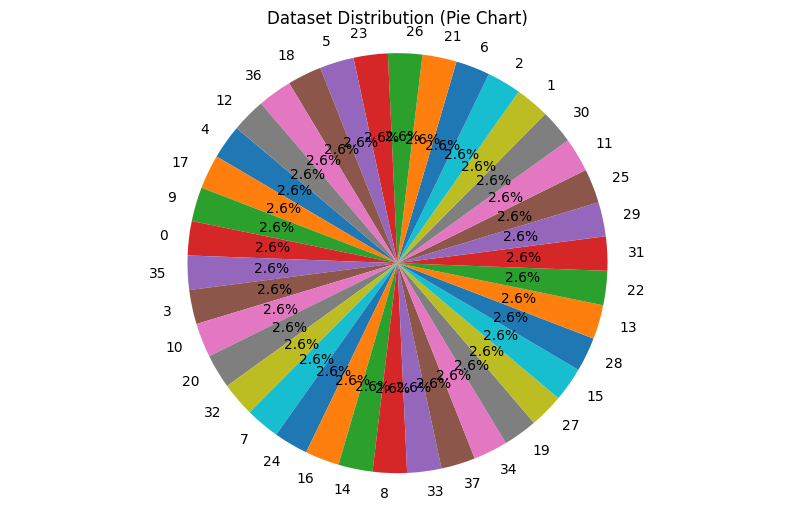

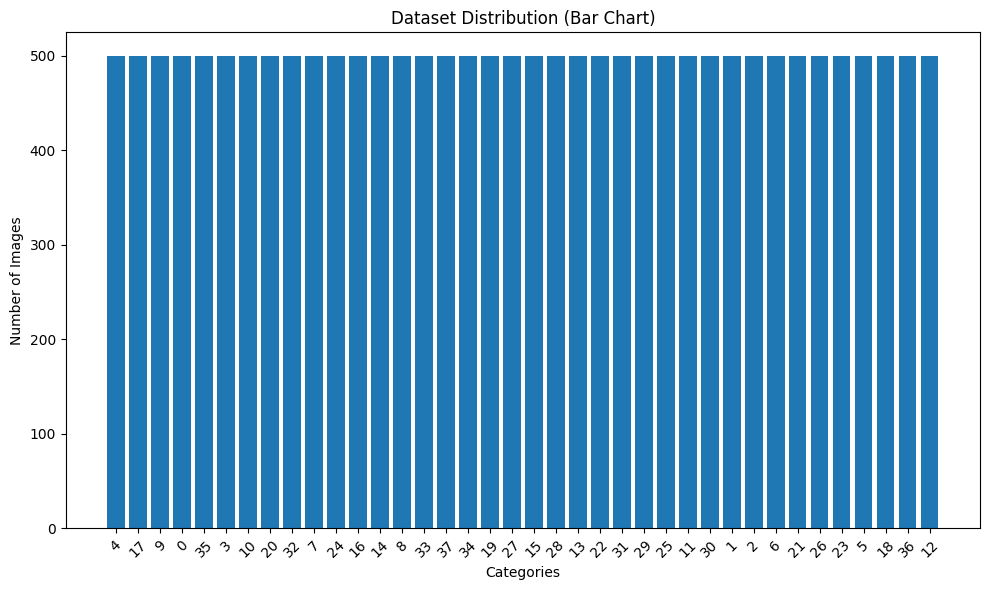

In [ ]:
category_counts = {}
for category in CATEGORIES:
    category_path = os.path.join(TRAIN_DATA_DIR, category)
    num_images = len(os.listdir(category_path))
    category_counts[category] = num_images


plt.figure(figsize=(10, 6), facecolor='white')
plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Dataset Distribution (Pie Chart)')
plt.axis('equal')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution (Bar Chart)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(training_data))

100%|██████████| 500/500 [00:04<00:00, 106.29it/s]

19000


In [ ]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(test_data))

100%|██████████| 200/200 [00:00<00:00, 286.19it/s]

7598


In [ ]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (19000, 64, 64, 3) Y_train= (19000,)


In [ ]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")
X_train, X_test = X_train / 255.0, X_test / 255.0

X_test= (7598, 64, 64, 3) Y_test= (7598,)


VGG19

In [ ]:
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.optimizers import Adam

VGG19_basic_model = VGG19(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
# Freeze all layers of the pre-trained model
for layer in VGG19_basic_model.layers:
    layer.trainable = False
VGG19_model = Sequential()
VGG19_model.add(VGG19_basic_model)
VGG19_model.add(Flatten())
VGG19_model.add(Dense(128, activation='relu'))
VGG19_model.add(Dense(classes, activation='softmax'))
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
VGG19_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
VGG19_pretrained = VGG19_model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/100
297/297 [==============================] - 18s 51ms/step - loss: 2.6537 - accuracy: 0.2915 - val_loss: 1.8552 - val_accuracy: 0.4766
Epoch 2/100
297/297 [==============================] - 13s 42ms/step - loss: 1.7807 - accuracy: 0.4956 - val_loss: 1.4521 - val_accuracy: 0.5723
Epoch 3/100
297/297 [==============================] - 12s 42ms/step - loss: 1.4953 - accuracy: 0.5706 - val_loss: 1.3156 - val_accuracy: 0.6024
Epoch 4/100
297/297 [==============================] - 13s 42ms/step - loss: 1.3301 - accuracy: 0.6112 - val_loss: 1.1484 - val_accuracy: 0.6485
Epoch 5/100
297/297 [==============================] - 12s 42ms/step - loss: 1.2199 - accuracy: 0.6428 - val_loss: 1.0424 - val_accuracy: 0.6868
Epoch 6/100
297/297 [==============================] - 14s 48ms/step - loss: 1.1265 - accuracy: 0.6669 - val_loss: 1.0281 - val_accuracy: 0.6816
Epoch 7/100
297/297 [==============================] - 14s 47ms/step - loss: 1.0608 - accuracy: 0.6801 - val_loss: 0.9409 - val_ac

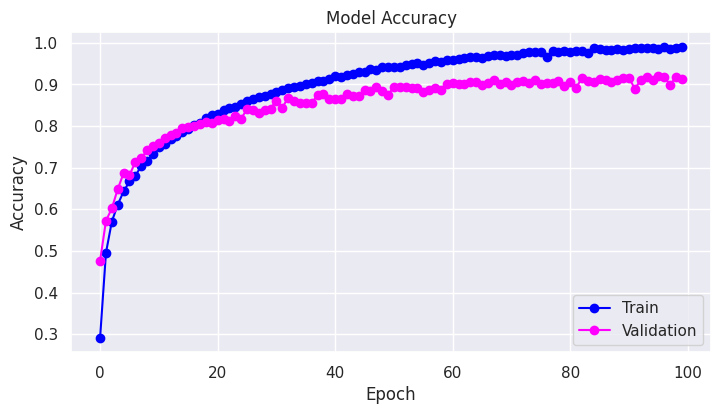

In [ ]:
#  "Accuracy"
import seaborn as sns
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(VGG19_pretrained.history['accuracy'], 'o-',color="blue")
plt.plot(VGG19_pretrained.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

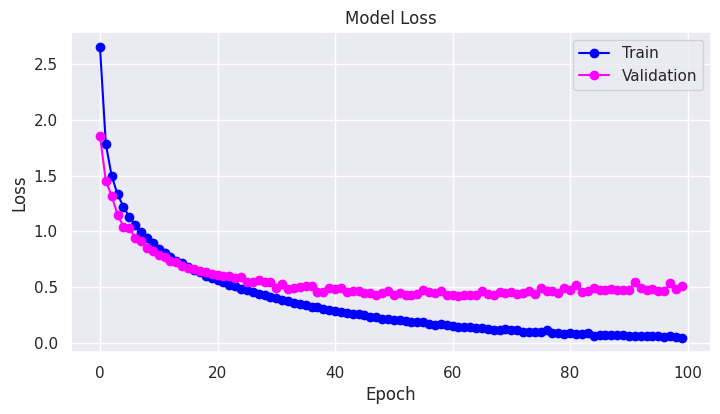

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(VGG19_pretrained.history['loss'],'o-', color="blue")
plt.plot(VGG19_pretrained.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
test_loss, test_acc = VGG19_model.evaluate(X_test, Y_test)
train_loss, train_acc=VGG19_model.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

594/594 [==============================] - 12s 20ms/step - loss: 0.0569 - accuracy: 0.9855

Test Accuracy: 0.9120821356773376

Test Loss: 0.5071194767951965

Train Accuracy: 0.9855263233184814

Train Loss: 0.05686591565608978


In [ ]:
score = VGG19_model.evaluate(X_test,Y_test,verbose=0)

print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  91.208 %


In [ ]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(VGG19_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

238/238 [==============================] - 4s 17ms/step
[ 5 19  3 ... 37 37 37]
(7598,)


In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[176,   0,   0, ...,   0,   0,   0],
       [  1, 184,   0, ...,   0,   0,   0],
       [  1,   0, 185, ...,   0,   0,   0],
       ...,
       [  2,   0,   0, ..., 152,   0,   0],
       [  0,   0,   0, ...,   0, 190,   5],
       [  0,   0,   0, ...,   0,   3, 173]])

In [ ]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

              precision    recall  f1-score   support

           4      0.898     0.880     0.889       200
          17      0.979     0.920     0.948       200
           9      0.885     0.925     0.905       200
           0      0.874     0.970     0.919       200
          35      0.954     0.930     0.942       200
           3      0.929     0.855     0.891       200
          10      0.891     0.940     0.915       200
          20      0.970     0.975     0.973       200
          32      0.984     0.900     0.940       200
           7      0.962     0.890     0.925       200
          24      0.912     0.935     0.923       200
          16      0.893     0.955     0.923       200
          14      0.832     0.915     0.871       200
           8      0.942     0.900     0.921       200
          33      0.906     0.820     0.861       200
          37      0.970     0.980     0.975       200
          34      0.984     0.935     0.959       200
          19      0.893    

In [ ]:
import pandas as pd
cm = pd.DataFrame(cm , index = CATEGORIES , columns = CATEGORIES)

<Axes: title={'center': 'Confusion Matrix'}>

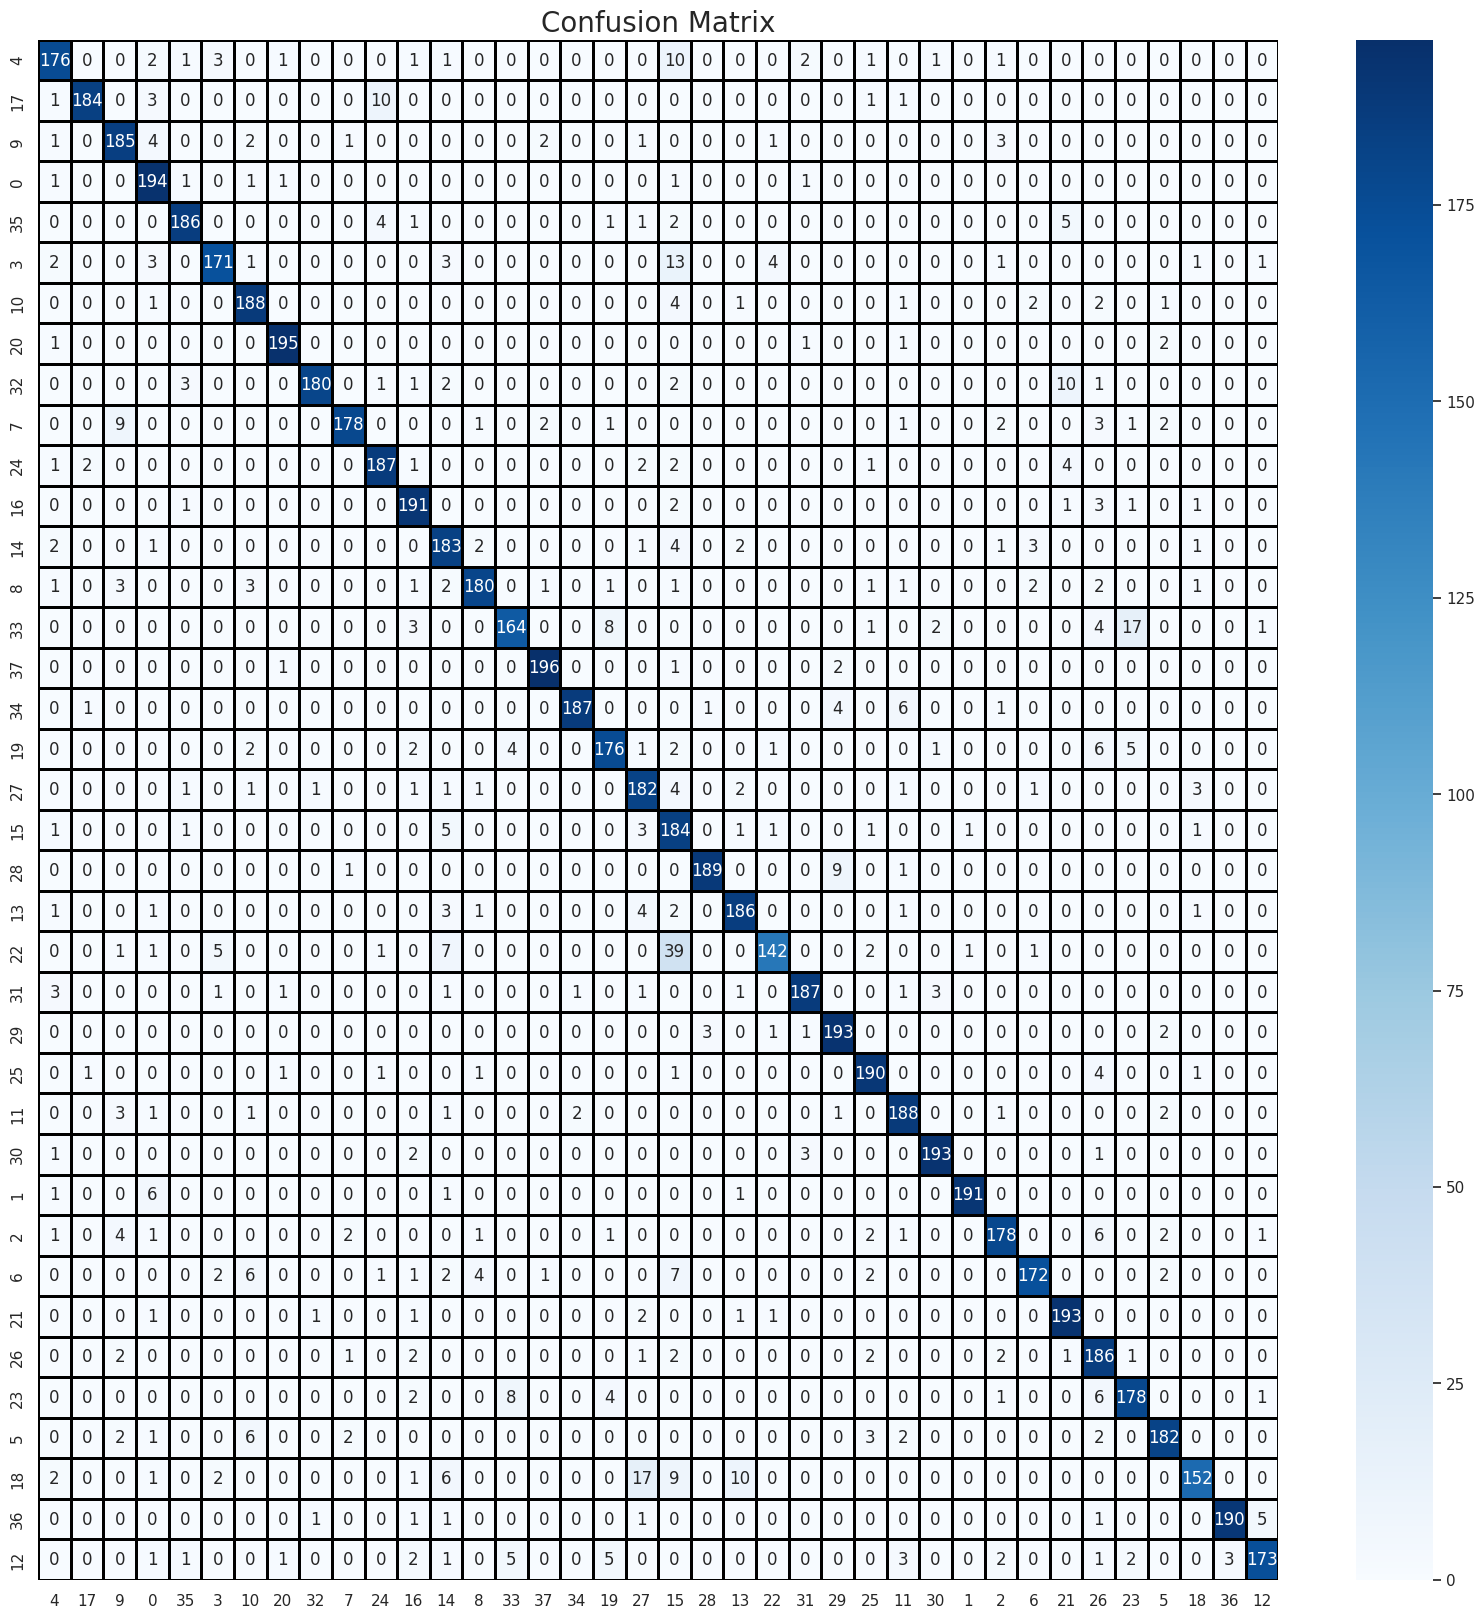

In [ ]:
plt.figure(figsize = (20,20))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

79/79 [==============================] - 1s 18ms/step


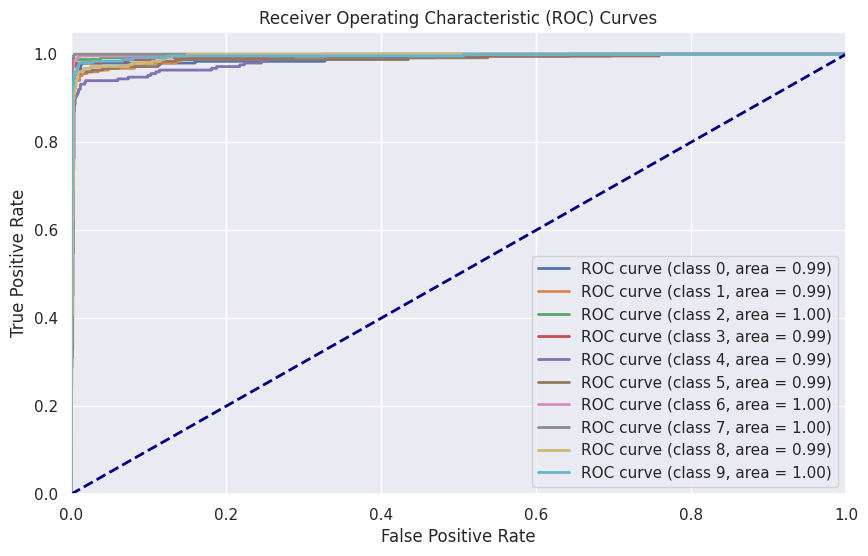

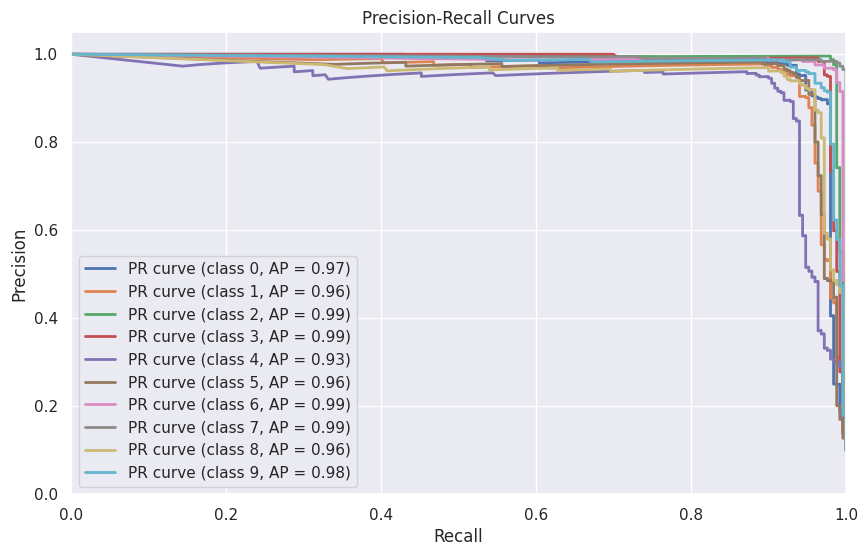

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = VGG19_model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()